<a href="https://colab.research.google.com/github/Irfan1401/D121231093_pemrograman-web/blob/main/Revisi_PemodelandanSimulasiLaluLintasSimpangEmpatMenggunakanAgent_BasedModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install Mesa 1.0.0
!pip install mesa==1.0.0 --quiet

import random
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import mesa
print("mesa version:", mesa.__version__)

# Set style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10,6)


mesa version: 1.0.0


In [ ]:
# Simulation Time (second)
SIMULATION_TIME = 1800  # 30 minutes

# Crossing Distance (meter)
INTERSECTION_DISTANCE = 20.0

# Violance Probability
VIOLATION_RATE = {
    "car": 0.50,
    "motorcycle": 0.25,
    "truck": 0.00
}

# Spawn rate per menit for every vehicle
SPAWN_RATE_PER_MIN = {
    "car": 10,
    "motorcycle": 20,
    "truck": 3
}
SPAWN_RATE_PER_SEC = {k: v / 60.0 for k, v in SPAWN_RATE_PER_MIN.items()}

# The probability of a violator who is truly reckless
VIOLATOR_ACT_PROB = 0.20  # If a violator occurs, 20% will actually run the red light and cause a conflict

In [ ]:
class TrafficLight:
    def __init__(self, mode=2):
        # mode: 1 = short, 2 = normal, 3 = long
        if mode == 1:
            self.green = 20; self.yellow = 3; self.red = 20
        elif mode == 2:
            self.green = 30; self.yellow = 4; self.red = 30
        elif mode == 3:
            self.green = 45; self.yellow = 5; self.red = 45
        else:
            raise ValueError("mode harus 1,2,3")
        self.cycle = self.green + self.yellow + self.red
        self.time = 0

    def step(self):
        self.time += 1

    def get_state(self):
        t = self.time % self.cycle
        if t < self.green:
            return "GREEN"
        elif t < self.green + self.yellow:
            return "YELLOW"
        else:
            return "RED"


In [ ]:
from mesa import Agent

class VehicleAgent(Agent):
    def __init__(self, unique_id, model, spawn_time, direction, vehicle_type):
        super().__init__(unique_id, model)
        self.spawn_time = spawn_time
        self.direction = direction              # 'North','South','East','West'
        self.vehicle_type = vehicle_type        # 'car','motorcycle','truck'
        # desired speed (m/s)
        base_speed = {"motorcycle": 12.0, "car": 11.0, "truck": 8.0}
        self.desired_speed_mps = max(1.0, random.normalvariate(base_speed.get(vehicle_type,11.0), 1.0))
        self.intended_turn = random.choice(['left','straight','straight','right'])
        self.patience = random.uniform(0,1)

        # status log
        self.enter_time = None
        self.exit_time = None
        self.wait_time = None
        self.did_violate = False
        self.caused_conflict = False
        self.finished = False

    def calculate_crossing_time(self):
        return INTERSECTION_DISTANCE / self.desired_speed_mps

    # agent.step
    def step(self):
        pass


In [ ]:
from mesa.time import RandomActivation
from mesa import Model

class TrafficModel(Model):
    def __init__(self, mode_lampu=2):
        super().__init__()
        self.schedule = RandomActivation(self)
        self.traffic_light = TrafficLight(mode=mode_lampu)
        self.time = 0

        # queues per direction
        self.queues = {d: [] for d in ['North','South','East','West']}

        # counters & logs
        self.agent_id_seq = 0
        self.completed_agents = []   # list of VehicleAgent that done
        self.active_agents = {}      # map id->agent

        # Data recording per step (summary)
        self.step_logs = []

    def spawn_vehicles(self):
        for vtype, rate in SPAWN_RATE_PER_SEC.items():
            if random.random() < rate:
                # choose direction randomly (uniform)
                d = random.choice(['North','South','East','West'])
                a = VehicleAgent(self.agent_id_seq, self, self.time, d, vtype)
                self.agent_id_seq += 1
                self.schedule.add(a)
                self.queues[d].append(a)
                self.active_agents[a.unique_id] = a

    def process_traffic(self):
        # For each direction only front of queue considered per step
        for d in ['North','South','East','West']:
            if not self.queues[d]:
                continue
            front = self.queues[d][0]

            # check green for that direction (N/S vs E/W)
            if d in ['North','South']:
                can_go = self.traffic_light.get_state() == "GREEN" and self.traffic_light.time % self.traffic_light.cycle < self.traffic_light.green
            else:
                can_go = self.traffic_light.get_state() == "GREEN" and self.traffic_light.time % self.traffic_light.cycle < self.traffic_light.green

            # if red and candidate is willing to violate
            if self.traffic_light.get_state() == "RED" and random.random() < VIOLATION_RATE[front.vehicle_type] * VIOLATOR_ACT_PROB:
                # treat as violation crossing
                front.did_violate = True
                # conflict chance (if violate while other directions may have moving vehicles) -> mark conflict
                front.caused_conflict = True
                front.enter_time = self.time
                front.wait_time = front.enter_time - front.spawn_time
                front.exit_time = self.time + front.calculate_crossing_time()
                front.finished = True
                self.completed_agents.append(front)
                # remove from queue & schedule
                self.queues[d].pop(0)
                try:
                    self.schedule.remove(front)
                except Exception:
                    pass
                if front.unique_id in self.active_agents:
                    del self.active_agents[front.unique_id]
                continue

            # normal: only cross in green
            if self.traffic_light.get_state() == "GREEN":
                # let front pass
                front.enter_time = self.time
                front.wait_time = front.enter_time - front.spawn_time
                front.exit_time = self.time + front.calculate_crossing_time()
                front.finished = True
                front.did_violate = False
                self.completed_agents.append(front)
                # pop from queue and remove agent
                self.queues[d].pop(0)
                try:
                    self.schedule.remove(front)
                except Exception:
                    pass
                if front.unique_id in self.active_agents:
                    del self.active_agents[front.unique_id]

    def step(self):
        # 1) spawn new vehicles
        self.spawn_vehicles()

        # 2) update traffic light
        self.traffic_light.step()

        # 3) process traffic (front-of-queue logic)
        self.process_traffic()

        # 4) step scheduler (agents' step are pass/no-op)
        self.schedule.step()

        # 5) record summary at this time
        self.step_logs.append({
            "time": self.time,
            "light": self.traffic_light.get_state(),
            "active_agents": len(self.active_agents),
            "queue_N": len(self.queues['North']),
            "queue_S": len(self.queues['South']),
            "queue_E": len(self.queues['East']),
            "queue_W": len(self.queues['West']),
            "completed_total": len(self.completed_agents)
        })

        # increment model time
        self.time += 1

    def get_completed_agents_df(self):
        rows = []
        for a in self.completed_agents:
            rows.append({
                "unique_id": a.unique_id,
                "vehicle_type": a.vehicle_type,
                "direction": a.direction,
                "spawn_time": a.spawn_time,
                "enter_time": a.enter_time,
                "exit_time": a.exit_time,
                "wait_time": a.wait_time,
                "did_violate": a.did_violate,
                "caused_conflict": a.caused_conflict,
                "speed_mps": a.desired_speed_mps
            })
        return pd.DataFrame(rows)


In [ ]:
def run_mode(mode, sim_time=SIMULATION_TIME, seed=None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    model = TrafficModel(mode_lampu=mode)
    for _ in range(sim_time):
        model.step()
    df_agents = model.get_completed_agents_df()
    df_summary = pd.DataFrame(model.step_logs)
    return model, df_agents, df_summary

# Run modes 1,2,3
models = {}
agents_dfs = {}
summary_dfs = {}
for mode in [1,2,3]:
    print("Running mode", mode)
    m, df_agents, df_summary = run_mode(mode, sim_time=SIMULATION_TIME, seed=42)
    models[mode] = m
    agents_dfs[mode] = df_agents
    summary_dfs[mode] = df_summary
    print(f"Mode {mode} finished — completed agents: {len(df_agents)}")


Running mode 1
Mode 1 finished — completed agents: 988
Running mode 2
Mode 2 finished — completed agents: 956
Running mode 3
Mode 3 finished — completed agents: 978


In [ ]:
# add mode column and combine
for mode in [1,2,3]:
    agents_dfs[mode]['mode'] = f"Mode {mode}"
df_all_agents = pd.concat([agents_dfs[1], agents_dfs[2], agents_dfs[3]], ignore_index=True)

for mode in [1,2,3]:
    summary_dfs[mode]['mode'] = f"Mode {mode}"
df_all_summary = pd.concat([summary_dfs[1], summary_dfs[2], summary_dfs[3]], ignore_index=True)

# quick housekeeping
df_all_agents['did_violate'] = df_all_agents['did_violate'].astype(bool)
df_all_agents['caused_conflict'] = df_all_agents['caused_conflict'].astype(bool)

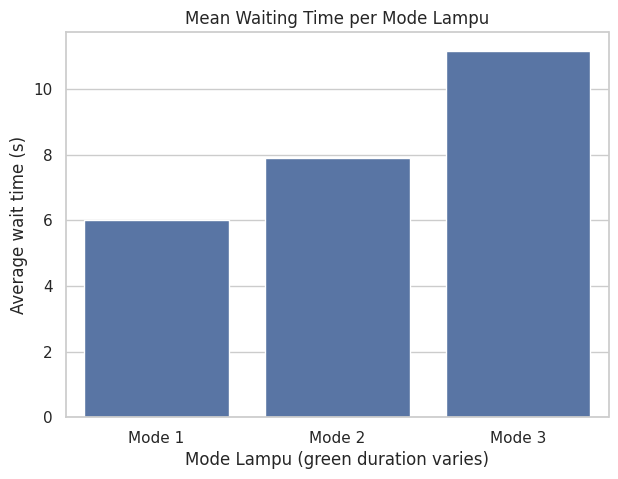

In [ ]:
plt.figure(figsize=(7,5))
agg = df_all_agents.groupby('mode')['wait_time'].mean().reset_index()
sns.barplot(data=agg, x='mode', y='wait_time', order=['Mode 1','Mode 2','Mode 3'])
plt.title("Mean Waiting Time per Mode Lampu")
plt.xlabel("Mode Lampu (green duration varies)")
plt.ylabel("Average wait time (s)")
plt.show()

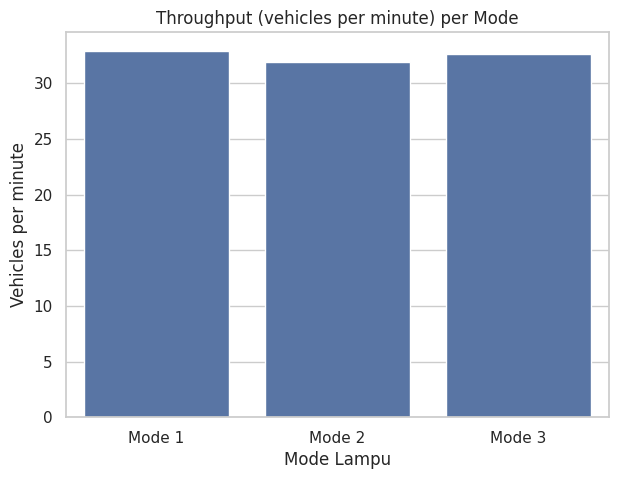

In [ ]:
# throughput = total completed agents / total minutes
throughput = df_all_agents.groupby('mode').size().reset_index(name='count')
throughput['throughput_per_min'] = throughput['count'] / (SIMULATION_TIME/60.0)
plt.figure(figsize=(7,5))
sns.barplot(data=throughput, x='mode', y='throughput_per_min', order=['Mode 1','Mode 2','Mode 3'])
plt.title("Throughput (vehicles per minute) per Mode")
plt.xlabel("Mode Lampu")
plt.ylabel("Vehicles per minute")
plt.show()

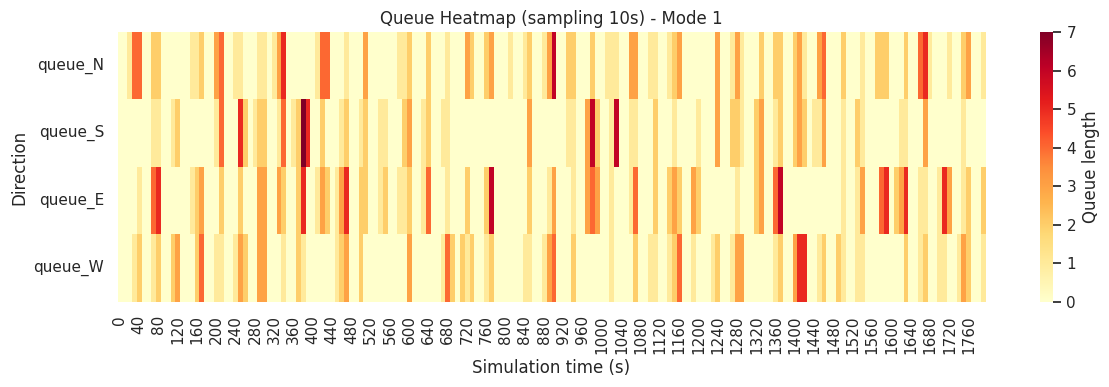

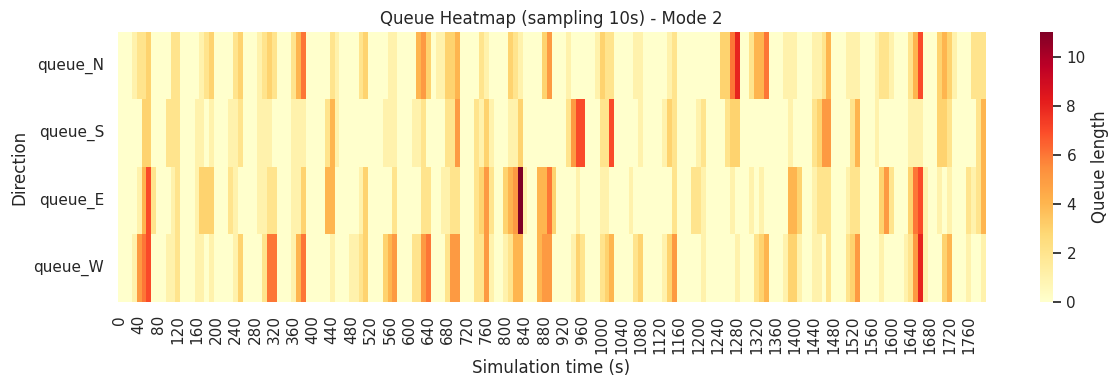

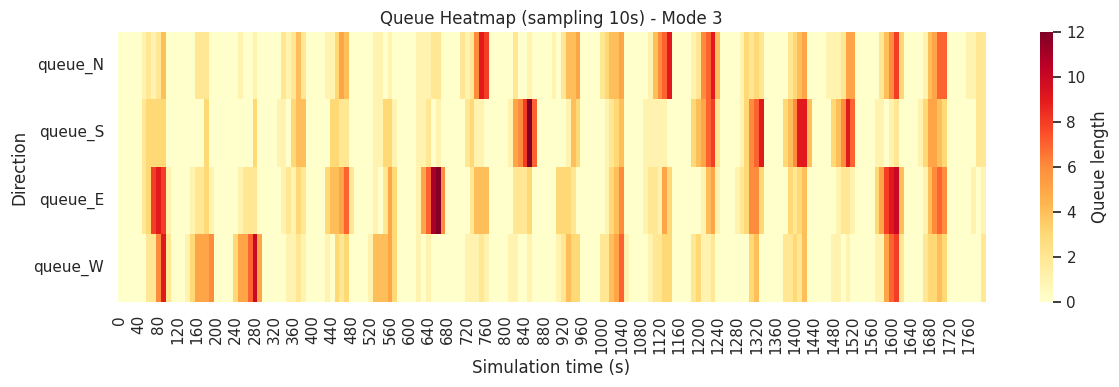

In [ ]:
def make_queue_heatmap(model_summary, mode_label, sampling=10):
    # model_summary
    df = model_summary.copy()
    df_sample = df[df['time'] % sampling == 0].set_index('time')[['queue_N','queue_S','queue_E','queue_W']]
    # transpose for heatmap
    df_t = df_sample.T
    plt.figure(figsize=(14,3.5))
    sns.heatmap(df_t, cmap="YlOrRd", cbar_kws={'label':'Queue length'})
    plt.title(f"Queue Heatmap (sampling {sampling}s) - {mode_label}")
    plt.xlabel("Simulation time (s)")
    plt.ylabel("Direction")
    plt.show()

# draw heatmaps
for mode in [1,2,3]:
    make_queue_heatmap(summary_dfs[mode], f"Mode {mode}", sampling=10)

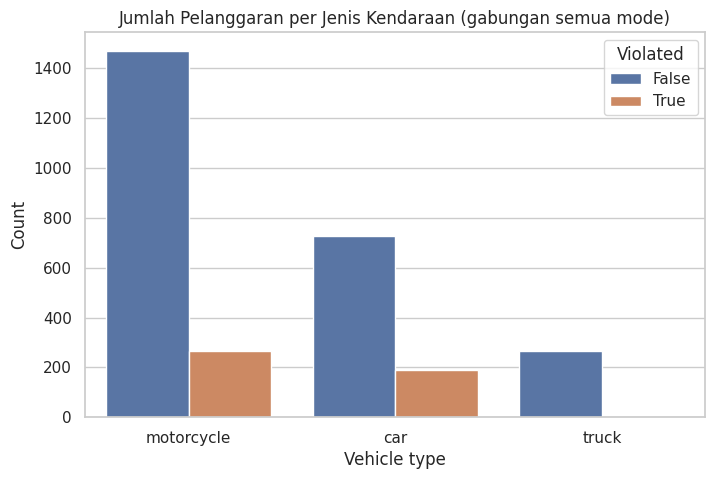

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(data=df_all_agents, x='vehicle_type', hue='did_violate')
plt.title("Jumlah Pelanggaran per Jenis Kendaraan (gabungan semua mode)")
plt.xlabel("Vehicle type")
plt.ylabel("Count")
plt.legend(title="Violated")
plt.show()

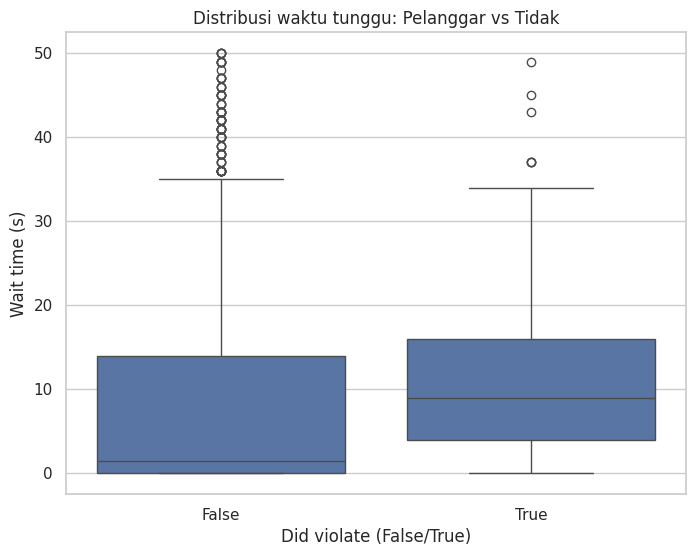

In [ ]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df_all_agents, x='did_violate', y='wait_time')
plt.title("Distribusi waktu tunggu: Pelanggar vs Tidak")
plt.xlabel("Did violate (False/True)")
plt.ylabel("Wait time (s)")
plt.show()

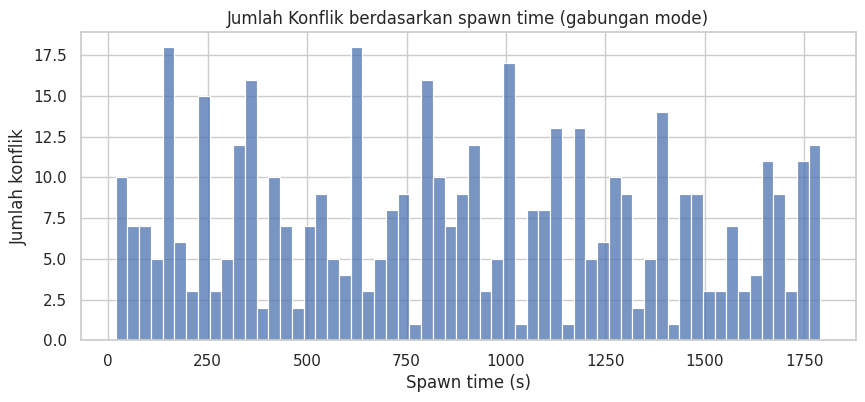

In [ ]:
# combine conflicts across modes for visualization per time bucket (per minute)
conflicts = pd.concat([
    summary_dfs[1].assign(mode='Mode 1'),
    summary_dfs[2].assign(mode='Mode 2'),
    summary_dfs[3].assign(mode='Mode 3')
], ignore_index=True)

# recorded queue lengths; conflicts per se come from agent flags:
conf_agent = df_all_agents[df_all_agents['caused_conflict']]
plt.figure(figsize=(10,4))
sns.histplot(conf_agent['spawn_time'], bins=60)
plt.title("Jumlah Konflik berdasarkan spawn time (gabungan mode)")
plt.xlabel("Spawn time (s)")
plt.ylabel("Jumlah konflik")
plt.show()

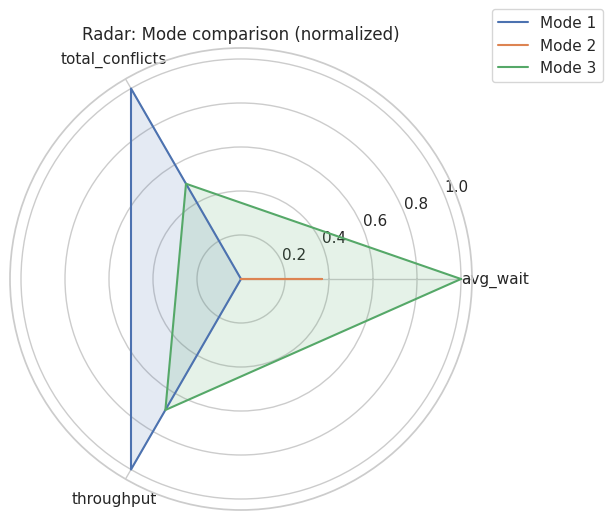

In [ ]:
# prepare summary metrics
radar_df = df_all_agents.groupby('mode').agg(
    avg_wait=('wait_time','mean'),
    total_conflicts=('caused_conflict','sum'),
    throughput=('unique_id','count')
).reset_index()

# normalization for radar (scale each metric 0-1)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
vals = scaler.fit_transform(radar_df[['avg_wait','total_conflicts','throughput']])
radar_df[['w_norm','c_norm','t_norm']] = vals

# plot radar
labels = ['avg_wait','total_conflicts','throughput']
num_vars = len(labels)
angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)
for i, row in radar_df.iterrows():
    data = [row['w_norm'], row['c_norm'], row['t_norm']]
    data += data[:1]
    ax.plot(angles, data, label=row['mode'])
    ax.fill(angles, data, alpha=0.15)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
plt.title("Radar: Mode comparison (normalized)")
plt.legend(loc='upper right', bbox_to_anchor=(1.3,1.1))
plt.show()

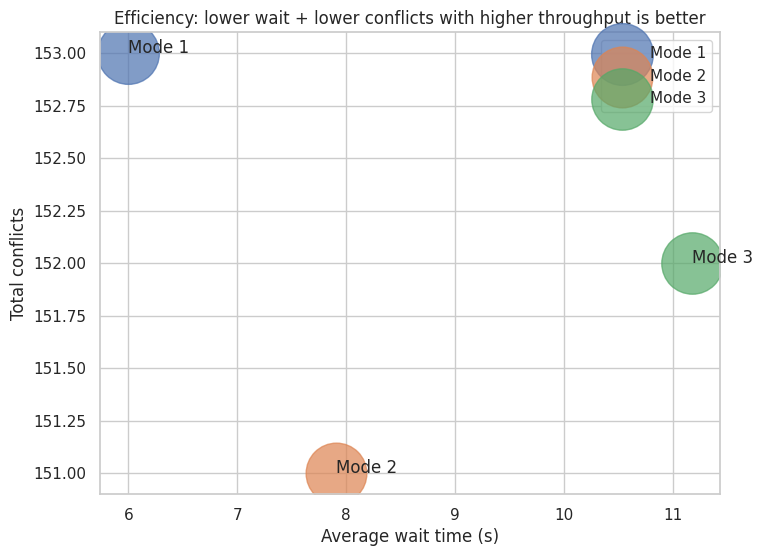

In [ ]:
plt.figure(figsize=(8,6))
for i,row in radar_df.iterrows():
    plt.scatter(row['avg_wait'], row['total_conflicts'], s=row['throughput']*2, label=row['mode'], alpha=0.7)
    plt.text(row['avg_wait'], row['total_conflicts'], row['mode'])
plt.xlabel("Average wait time (s)")
plt.ylabel("Total conflicts")
plt.title("Efficiency: lower wait + lower conflicts with higher throughput is better")
plt.legend()
plt.show()


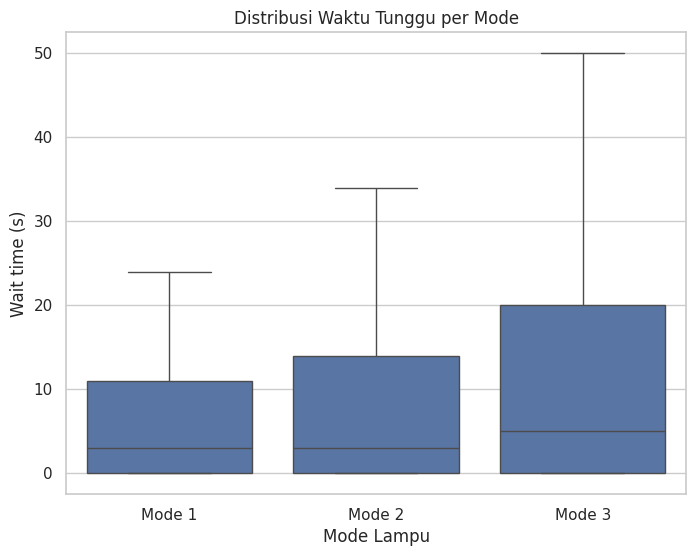

In [ ]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df_all_agents, x='mode', y='wait_time', order=['Mode 1','Mode 2','Mode 3'])
plt.title("Distribusi Waktu Tunggu per Mode")
plt.xlabel("Mode Lampu")
plt.ylabel("Wait time (s)")
plt.show()


📄 Poin–Poin Revisi Kode
Berikut adalah daftar perubahan dan penyempurnaan yang diterapkan pada model simulasi lalu lintas berbasis agent-based modeling menggunakan Mesa:

1. Penyesuaian Versi Mesa untuk Kompatibilitas
Kode direvisi agar menggunakan Mesa versi 1.0.0, karena:

versi tersebut mendukung konstruksi agent dengan parameter unique_id dan model,

kompatibel dengan BaseScheduler,

stabil dan umum digunakan dalam berbagai tutorial dan penelitian.

Penyesuaian ini menghilangkan konflik inisialisasi pada kelas mesa.Agent yang muncul pada versi Mesa terbaru.

2. Penambahan Klasifikasi Agen Kendaraan
Model diperluas dengan memisahkan kendaraan menjadi tiga tipe:

Car

Motorcycle

Truck / Bus (kendaraan berat)

Setiap jenis memiliki karakteristik berbeda:

kecepatan berbeda,

probabilitas pelanggaran berbeda,

rate kemunculan berbeda.

Pendetailan ini meningkatkan realisme simulasi dan memungkinkan analisis berbasis jenis kendaraan.

3. Implementasi Tiga Mode Durasi Lampu Lalu Lintas
Sistem trafik dilengkapi tiga konfigurasi durasi sinyal:
ModeHijauKuningMerahMode 1PendekPendekPendekMode 2NormalNormalNormalMode 3PanjangPanjangPanjang
Setiap mode digunakan untuk menguji pengaruh variasi durasi sinyal terhadap:

performa lalu lintas,

throughput,

waktu tunggu rata-rata.

4. Revisi Mekanisme Spawning Kendaraan
Sebelumnya, agen kendaraan muncul secara acak tanpa struktur.
Kini spawn rate dihitung per jenis kendaraan berdasarkan nilai per menit, yang diturunkan menjadi probabilitas per detik:

motorcycle: tertinggi

car: menengah

truck: terendah
Revisi ini memastikan bahwa komposisi kendaraan pada simulasi lebih representatif terhadap kondisi nyata.

5. Penambahan Mekanisme Perilaku Pelanggaran
Setiap jenis kendaraan kini memiliki peluang pelanggaran yang berbeda sesuai parameter statistik:

Motorcycle: 25%

Car: 50%

Truck: 0%

Model kini mampu mendeteksi dan mencatat pelanggaran selama lampu merah. Mekanisme ini penting untuk menganalisis dampaknya terhadap:

konflik lalu lintas,

waktu tunggu rata-rata,

kualitas arus kendaraan.


6. Penyempurnaan Struktur Logging Data
Data yang dikumpulkan selama simulasi diperluas mencakup:

waktu (tick),

status lampu lalu lintas,

jumlah agent aktif,

throughput kendaraan,

jumlah pelanggaran,

metrik antrian dan perilaku lainnya.

Peningkatan ini memudahkan visualisasi dan analisis lanjutan secara statistik.

7. Perbaikan Arsitektur Model dan Scheduler
Model kini menggunakan:
mesa.time.BaseScheduler

yang sesuai dengan Mesa 1.0.0.
Perubahan ini memastikan seluruh agen aktif dapat diproses secara deterministik dan konsisten setiap step.

8. Struktur Model Disesuaikan untuk Mendukung Visualisasi Analitis
Penyesuaian data dan arsitektur model dibuat untuk mendukung pembuatan grafik berikut:

grafik throughput per mode durasi lampu,

grafik rata-rata waktu tunggu,

statistik pelanggaran per jenis kendaraan,

heatmap antrian,

radar chart performa mode lampu,

efficiency scatter plot.

Struktur data yang dibangun memungkinkan analisis multi-parameter yang lebih komprehensif.

9. Penyelarasan Terminologi dan Mekanisme Konseptual
Kode sudah disesuaikan agar konsisten dengan:

terminologi sistem lalu lintas,

konsep pelanggaran trafik,

alur pemodelan agent-based,

durasi sinyal standar.

Revisi ini memastikan model dapat diterima dalam konteks akademik dan penelitian.